In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,Embedding, ReLU,concatenate,Cropping2D, BatchNormalization

from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-20 20:26:10.118499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
def generate_clean_captcha(char):
    # Fixed parameters
    size = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate the position to center the character in the image
    text_size = cv2.getTextSize(char, font, font_scale, font_thickness)[0]
    text_x = (size[1] - text_size[0]) // 2  # Center horizontally
    text_y = (size[0] + text_size[1]) // 2  # Center vertically

    # Draw the character at the calculated position
    cv2.putText(image, char, (text_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    
    return image

In [7]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [8]:
def generate_X_Y(image_path):
  df = generate_df(image_path)

  df["index"] = [f"{i}" for i in range(len(df))]
  file_index = (df["index"] + " ") * df['txt_content'].str.len()
  file_index = file_index.sum().split(" ")
  file_index = [int(x) for x in file_index if x] 

  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)


  X   = X[file_index]
  Y   = np.array([generate_clean_captcha(char) for char in df["txt_content"].sum()])
  pos = np.array([i for text in df["txt_content"] for i,char in enumerate(text)]).reshape(-1,1)


  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y,pos

X_train,Y_train,pos_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val,Y_val,pos_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

In [9]:
def create_tf_dataset(X, Y, pos):
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    Y_ds = tf.data.Dataset.from_tensor_slices(Y)
    POS_ds = tf.data.Dataset.from_tensor_slices(pos)

    dataset = tf.data.Dataset.zip(((X_ds, POS_ds), Y_ds))
    
    def preprocess_data(inputs, Y):
        X, POS = inputs
        return (X, POS), Y

    dataset = dataset.map(preprocess_data)
    return dataset

# Create the dataset
train_set   = create_tf_dataset(X_train, Y_train, pos_train)
val_set     = create_tf_dataset(X_val, Y_val, pos_val)


# Shuffle and batch the dataset
batch_size  = 64
train_set   = train_set.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_set     = val_set.batch(batch_size)

2024-07-20 20:26:15.793353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13841 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


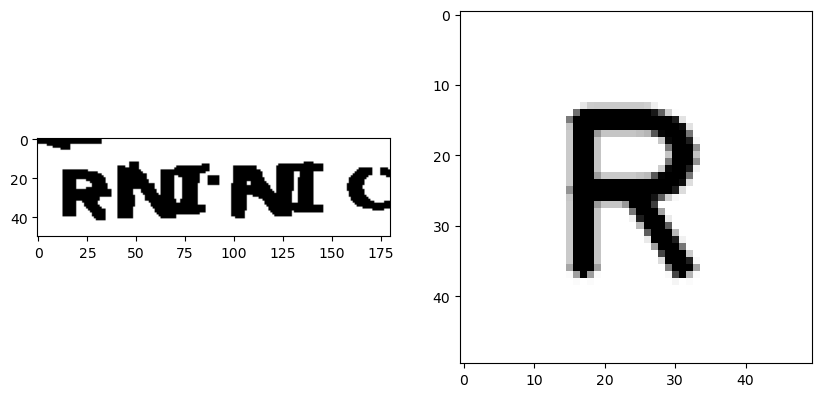

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [11]:
# datagen = ImageDataGenerator(
#     rotation_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.05,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     fill_mode='nearest'
# )

# datagen.fit(X_train)
# batch_size = 64
# augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

In [12]:
# augmented_images, augmented_labels = next(augmented_data_generator)

# # Display the first few augmented images and their corresponding labels
# plt.figure(figsize=(9, 9))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [14]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

In [15]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

def crop(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return x2_cropped

In [16]:
def uc_net(input_img, input_pos, num_blocks=1, num_downsample=3):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(64, (3, 3))(x)

    # Contracting path
    res = []
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        res.append(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)
    shape_before_flattening = x.shape[1:]
    
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)

    # change to use embedding layer
    pos_emb = Embedding(input_dim=7, output_dim=32)(input_pos)
    pos_emb = Flatten()(pos_emb)  # Flatten the embedding output


    x = concatenate([x, pos_emb])

    x = Dense(tf.reduce_prod(shape_before_flattening), activation='relu')(x)
    x = Reshape(shape_before_flattening)(x)

    # Expansive path
    for i in range(num_downsample - 1, -1, -1):
        x = UpSampling2D((2, 2))(x)
        x = crop_and_concat(res[i], x)
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
    x = Cropping2D(cropping=((0, 0), (0, 180-50)))(x)
    
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)

    output = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=[input_img, input_pos], outputs=output)

input_shape = X_train[0].shape  # Example input shape
pos_shape = pos_train[0].shape 
input_img = Input(shape=input_shape, name='input_img')
input_pos = Input(shape=(pos_shape), name='input_pos')
autoencoder = uc_net(input_img, input_pos, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rmse,psnr])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 180, 64)          640       ['input_img[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 50, 180, 64)          256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 50, 180, 64)          0         ['batch_normalization[0][0

In [17]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [18]:
# history = autoencoder.fit(train_set,
#                 epochs=300,
#                 batch_size=batch_size,
#                 shuffle=True,
#                 callbacks=[checkpoint],
#                 validation_data=val_set)

In [19]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})

In [20]:
train_set   = create_tf_dataset(X_train, Y_train, pos_train)
batch_size  = 64

train_set   = train_set.batch(batch_size)

In [21]:
Y_train_pred = autoencoder.predict(train_set)
Y_val_pred = autoencoder.predict(val_set)

2024-07-20 20:26:29.484665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-20 20:26:31.080120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


94/94 [==============================] - 5s 51ms/step


In [22]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 50), cmap="gray")
        plt.title(f"Y {pos_train[idx]}")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 50), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

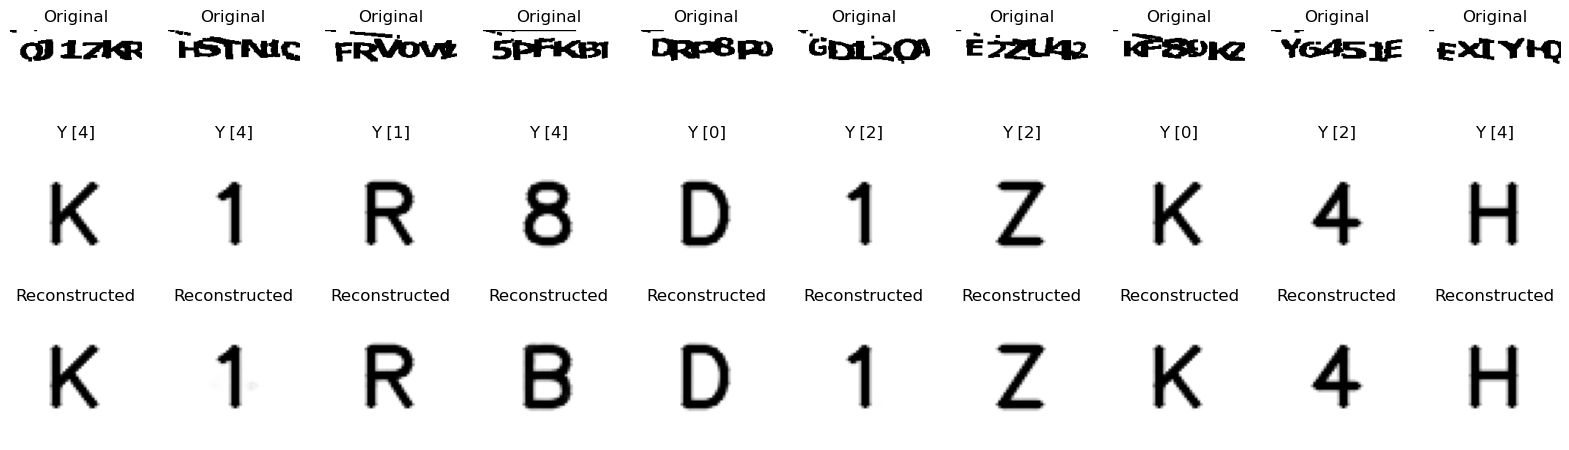

In [23]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

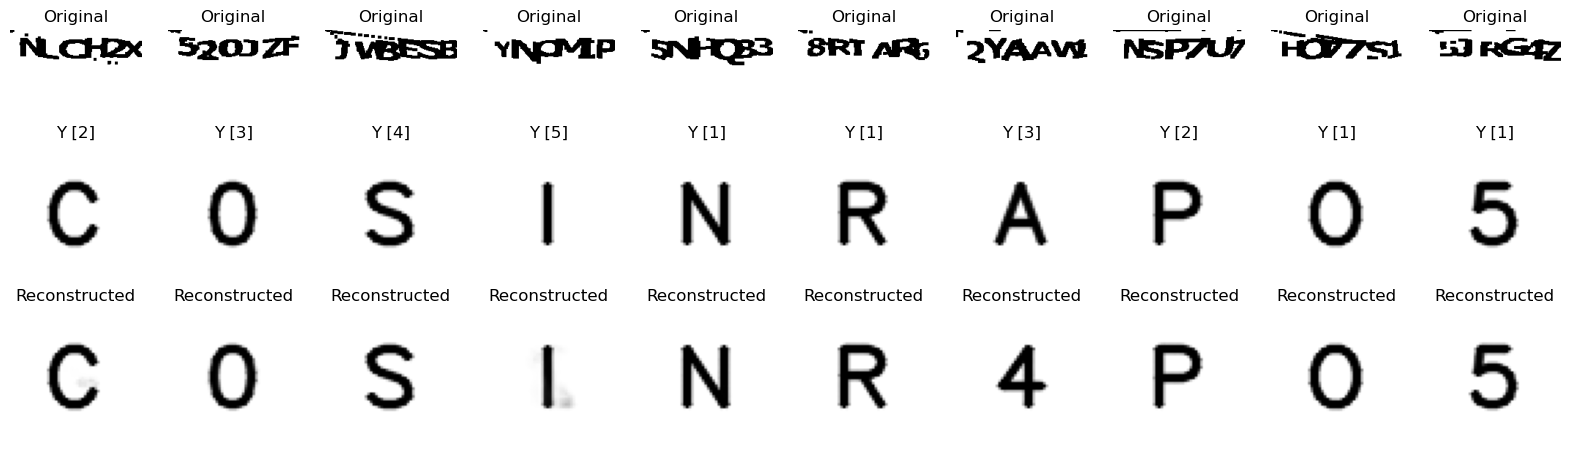

In [24]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)

In [25]:
autoencoder.save('model_BCE_aug_200_unet.keras')

In [26]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})

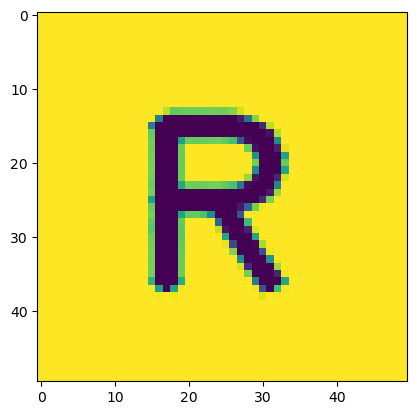

In [27]:
img = X_train[0]
pos = np.array([0]) 
img = np.expand_dims(img, axis=0)  # Add batch dimension if needed
pos = np.expand_dims(pos, axis=0)  # Add batch dimension if needed
plt.imshow(autoencoder([img,pos])[0])